In [1]:
import torch
import numpy as np
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import math
import timm
import pathlib
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

from utils.adapter_decoder import Decoder, Config
from tokenizer import BPETokenizer
from p2_dataset import build_dataset
from utils.p2_model import ViL

myseed = 53  # set a random seed for reproducibility
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(myseed)
    torch.cuda.manual_seed_all(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
class p3_dataset(Dataset):
    def __init__(self, root, transform) -> None:
        super().__init__()

        self.Transform = transform
        self.Image_names = [p for p in root.glob("*")]

    def __getitem__(self, idx):
        img = Image.open(self.Image_names[idx]).convert('RGB')
        img = self.Transform(img)
        img = img.unsqueeze(0)

        return img, os.path.splitext(os.path.basename(self.Image_names[idx]))[0]

    def __len__(self):
        return len(self.Image_names)

In [3]:
decoder_weight_path = "./hw3_data/p2_data/decoder_model.bin"
encoder_model = timm.create_model("vit_large_patch14_clip_336.openai_ft_in12k_in1k", pretrained = True, num_classes = 0)
decoder_model = Decoder(Config(checkpoint = decoder_weight_path)) # decoder from TA

In [4]:
data_config = timm.data.resolve_model_data_config(encoder_model)
val_tfm = timm.data.create_transform(**data_config, is_training = False)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BPETokenizer(encoder_file = "./encoder.json", vocab_file = "./vocab.bpe")
p3_img = p3_dataset(root = pathlib.Path("./hw3_data/p3_data/images"), transform = val_tfm)

In [6]:
model = ViL(encoder = encoder_model, decoder = decoder_model)
pth_path = "./p2_results/p2_adapter/p2_7_adapter_1.pth"
checkpoint = torch.load(pth_path, map_location = 'cpu')
print(sum([p.numel() for n, p in checkpoint.items()]))
model.load_state_dict(checkpoint, strict = False)
model.to(device)
model.eval()

34450944


ViL(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=40

In [7]:
def register_attention_hook(model, features):
    handle_decoder = None
    def hook_decoder(module, ins, outs):
        features.append(outs[1].detach().cpu())
    for i, block in enumerate(model.decoder.transformer.h):
        if i == 11:
            handle_decoder = block.multihead_attention.register_forward_hook(hook_decoder)
    return [handle_decoder]

In [8]:
def vis_atten_map(atten_mat, ids, image_fn, image_path):
    nrows = len(ids) // 5 if len(ids) % 5 == 0 else len(ids) // 5 + 1
    ncols = 5
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 8))
    feature_size = (24, 24)  # H/patch size, W/patch size = feature size
    for i, id in enumerate(ids):
        # print(atten_mat)
        attn_vector = atten_mat[:, i - 1, 1:]
        attn_map = torch.reshape(attn_vector, feature_size)
        attn_map -= torch.min(attn_map)
        attn_map /= torch.max(attn_map)
        # print(torch.min(attn_map), torch.max(attn_map))
        # print(attn_map.size())
        im = Image.open(image_path)
        size = im.size
        mask = resize(attn_map.unsqueeze(0), [size[1], size[0]]).squeeze(0)
        mask = np.uint8(mask * 255)
        # print(mask.shape)
        ax[i // 5][i % 5].imshow(im)
        if i == 0:
            ax[i // 5][i % 5].set_title('<|endoftext|>')
        else:
            ax[i // 5][i % 5].set_title(id)
            ax[i // 5][i % 5].imshow(mask, alpha=0.7, cmap='jet')
        ax[i // 5][i % 5].axis('off')
    for i in range(len(ids), nrows * ncols):
        ax[i // 5][i % 5].axis('off')
    plt.savefig((pathlib.Path("./p3_output") / image_fn))

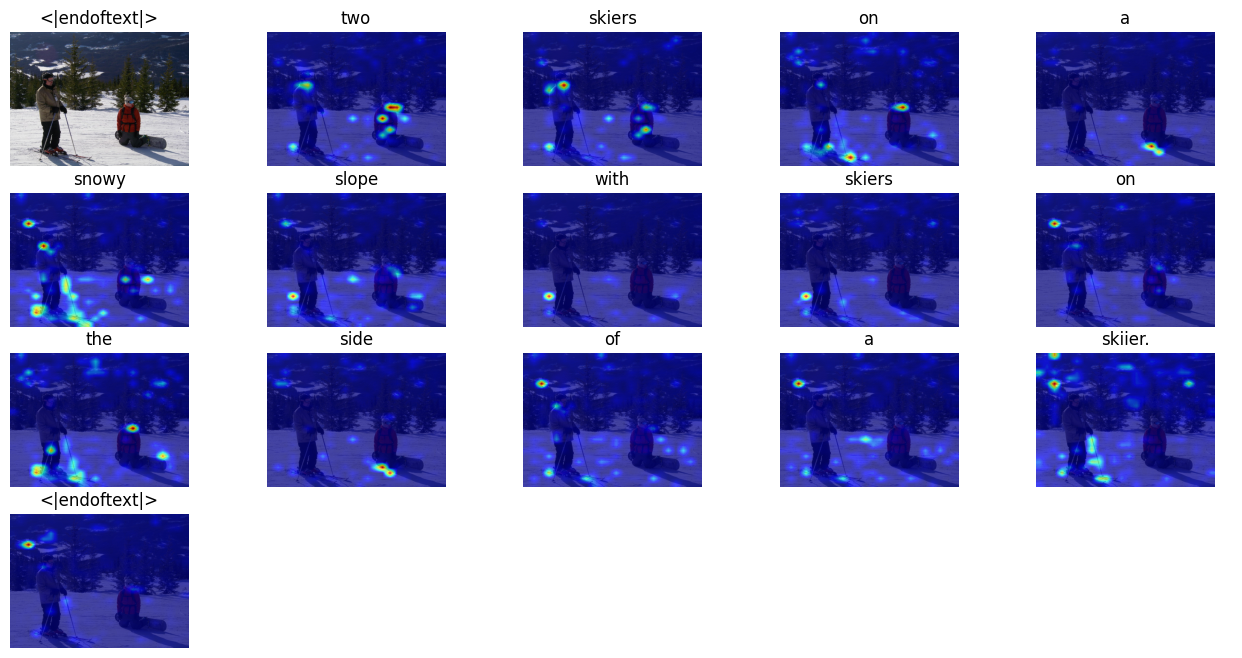

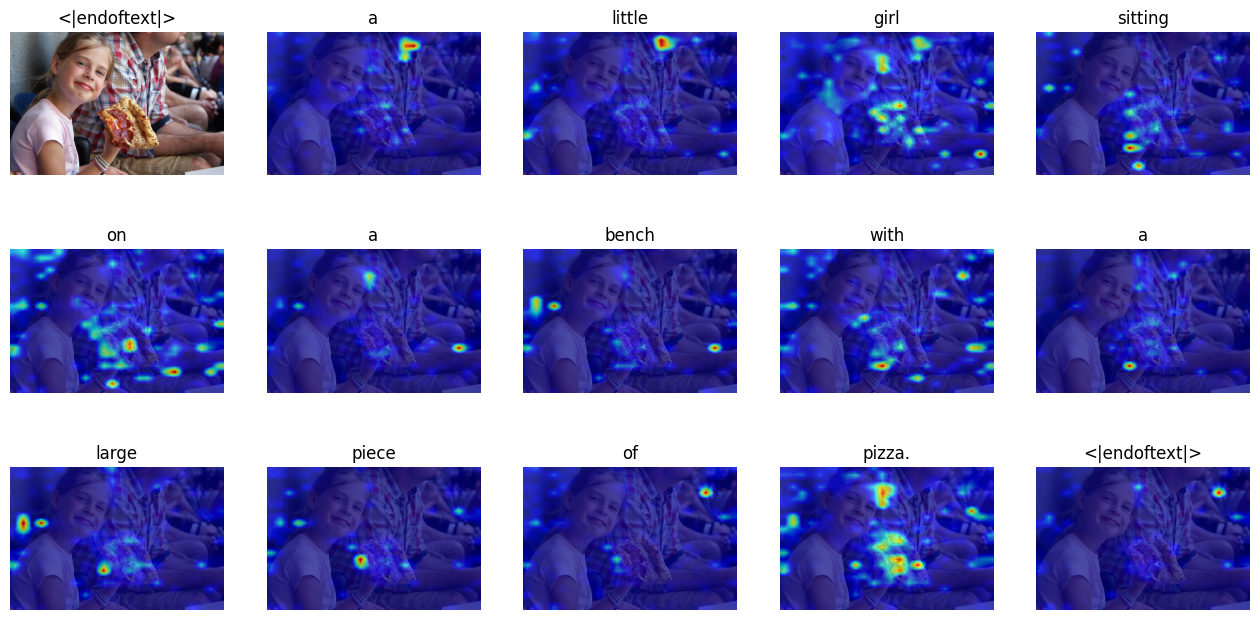

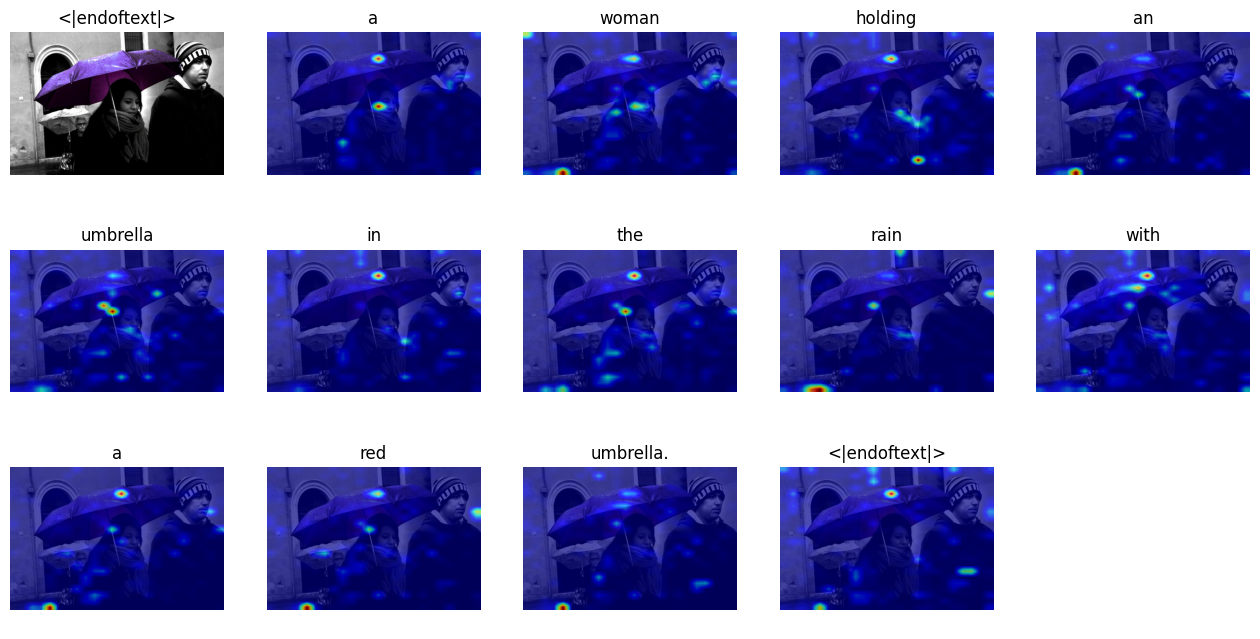

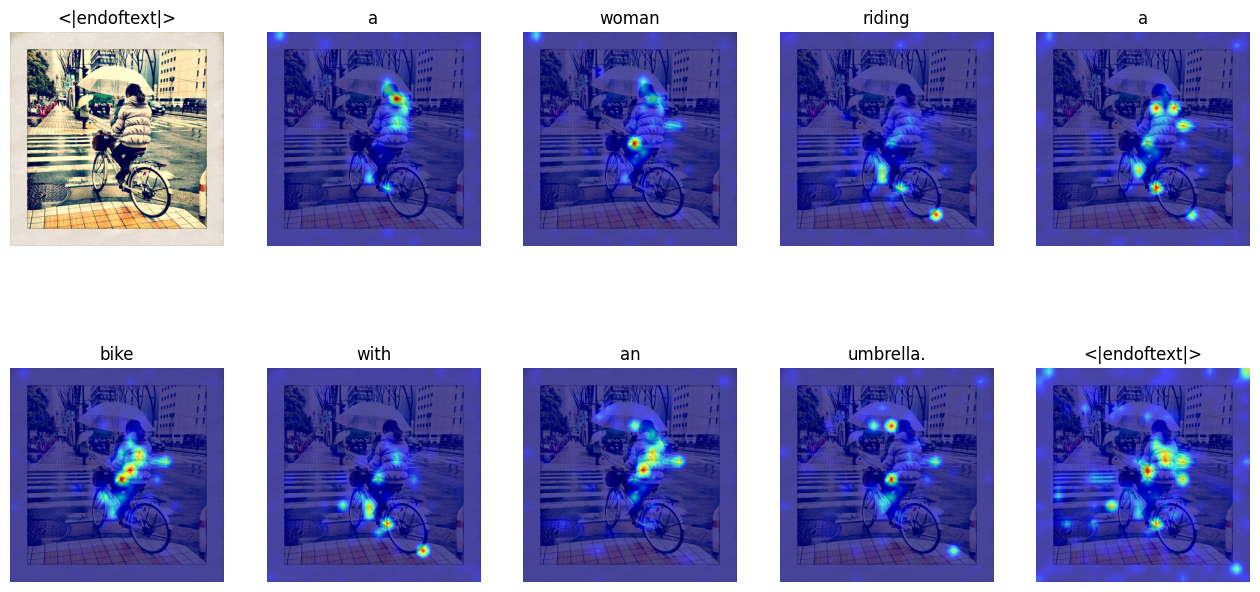

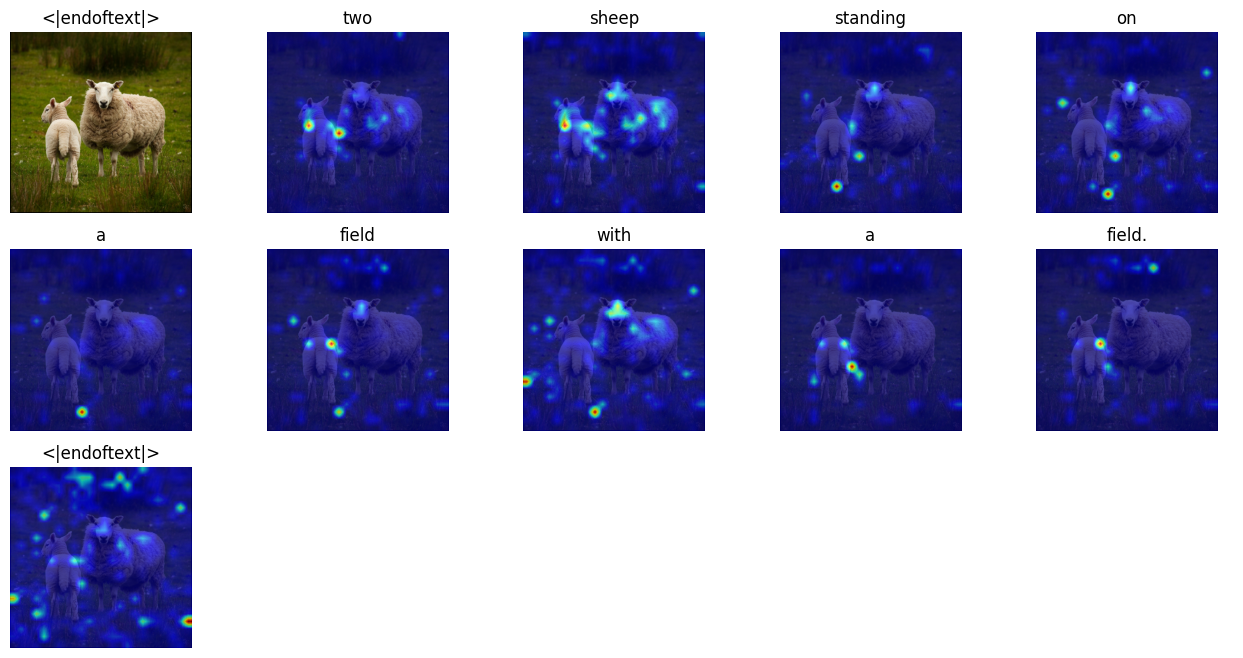

In [9]:
max_length = 96
for image, name in p3_img:
    features = []
    caption = torch.zeros((1, max_length), dtype = torch.long) # set all zero
    caption[:, 0] = 50256
    output = []
    
    for j in range(max_length - 1):
        image = image.to(device)
        caption = caption.to(device)
        to_rm_l = register_attention_hook(model, features)
        with torch.no_grad():
            predictions = model(image, caption)
        predictions = predictions[:, j, :]
        predicted_id = torch.argmax(predictions, axis = -1)

        # drop padding
        if predicted_id[0].item() == 50256:
            break
        if j == 71:
            break

        caption[:, j+1] = predicted_id[0]
        output.append(predicted_id[0].item())

    result = tokenizer.decode(np.array(output))
    result = "<|endoftext|> " + result + " <|endoftext|>"
    result_list = result.split()
    attention_matrix = features[-1]
    vis_atten_map(attention_matrix, result_list, name, (pathlib.Path("./hw3_data/p3_data/images") / name).with_suffix('.jpg'))

    for handle in to_rm_l:
        handle.remove()
